In [1]:
# Copyright 2020 Francesco Montanari

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import xgboost as xgb

import stream_utils as stu

In [4]:
def set_matplotlib_font(size):
    font = {'size': size}
    matplotlib.rc('font', **font)

set_matplotlib_font(14)    

# Common utilities

In [5]:
def load_data(pfile, random_state=None):
    """Load data dictionnary."""
    ll, X, y = stu.load_data_Qrho(pfile, sigma_shot=0.1)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, random_state=random_state)
    return {
        'll': ll,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
    }


def _plot_X_class(ax, ll, X, y, y_class, fmt, label):
    for i, x in enumerate(X[y == y_class]):
        if i == 0:
            ax.plot(ll, x, fmt, label=label)
        else:
            ax.plot(ll, x, fmt, alpha=0.05)


def preprocess(data, n_components=8):
    """Return preprocessed data, including pipeline and transformer."""
    data = dict(data)
    pipe = Pipeline([
        ('scale0', preprocessing.StandardScaler()),
        ('pca', decomposition.PCA(n_components=n_components)),
    ])
    transformer = pipe.fit(data['X_train'])
    data['X_train'] = transformer.transform(data['X_train'])
    data['X_val'] = transformer.transform(data['X_val'])
    data['X_test'] = transformer.transform(data['X_test'])
    data['pipeline'] = pipe
    data['transformer'] = transformer
    return data


def describe_pca(pca):
    """Plot PCA explained variance."""
    var_ratio = pca.explained_variance_ratio_
    plt.plot(var_ratio, '.')
    plt.xlabel('n_components')
    plt.ylabel('Explained variance [%]')
    plt.show()
    print(f"n_components: {pca.n_components_}")
    print(f"Total explained variance: {np.sum(var_ratio)*100}%")


def build_model():
    """Build gradient boosting model."""
    parameters = {
        'max_depth': [2, 4, 8, 64, 128],
        'n_estimators': [10, 50, 100, 200],
    }
    return GridSearchCV(xgb.XGBClassifier(), parameters, cv=5, n_jobs=-1)

# Binary, single-label classification of mass ranges

## Load data

In [13]:
DATA = load_data(
    '/home/francesco/Data/streams/scripts_data/Xy_obs_density_2classes.pkl',
    random_state=812)

Filtered 25 dens<0 samples


In [8]:
_STEPS = np.diff(DATA['ll'])
assert np.allclose(_STEPS - _STEPS[0], [0] * len(_STEPS))
print(f"Angular bins size: {_STEPS[0]} deg")

Angular bins size: 0.21812629370964487 deg


In [9]:
for set_ in ['train', 'val', 'test']:
    print(f"{set_}:")
    print(f"  Shape X: {DATA['X_' + set_].shape}, y: {DATA['y_' + set_].shape}")
    print(
        f"  # of samples for the two categories: " + 
        f"({np.count_nonzero(DATA['y_' + set_]==0)}, " + 
        f"{np.count_nonzero(DATA['y_' + set_]==1)})"
    )

train:
  Shape X: (2436, 322), y: (2436,)
  # of samples for the two categories: (1134, 1302)
val:
  Shape X: (812, 322), y: (812,)
  # of samples for the two categories: (376, 436)
test:
  Shape X: (1083, 322), y: (1083,)
  # of samples for the two categories: (517, 566)


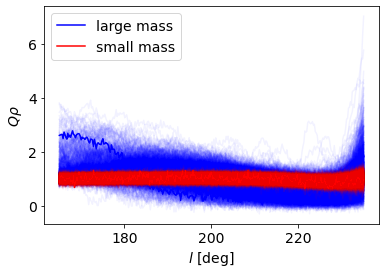

In [11]:
def plot_X(ll, X, y):
    """Plot Qrho samples."""
    fig, ax = plt.subplots()
    _plot_X_class(ax, ll, X, y, 1, 'b', 'large mass')
    _plot_X_class(ax, ll, X, y, 0, 'r', 'small mass')
    ax.set_xlabel("$l$ [deg]")
    ax.set_ylabel(r"$Q\rho$")
    ax.legend()


plot_X(DATA['ll'], DATA['X_train'], DATA['y_train'])

Small mass:


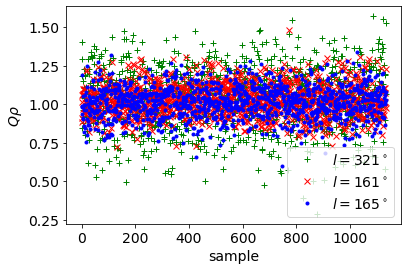

Large mass:


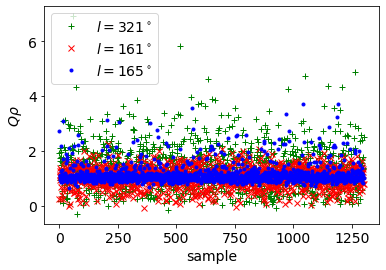

In [15]:
def plot_samples_at_l(ll, X):
    """Plot Qrho samples at selected longitude values."""
    fig, ax = plt.subplots()
    ax.plot(X[:, len(ll) - 1],
            'g+',
            label="$l={:3.0f}^\circ$".format(len(ll) - 1))
    ax.plot(X[:, len(ll) // 2],
            'rx',
            label="$l={:3.0f}^\circ$".format(len(ll) // 2))
    ax.plot(X[:, 0], 'b.', label="$l={:3.0f}^\circ$".format(ll[0]))
    ax.set_xlabel("sample")
    ax.set_ylabel(r"$Q\rho$")
    ax.legend()
    return fig, ax


print("Small mass:")
plot_samples_at_l(DATA['ll'], DATA['X_train'][DATA['y_train'] == 0])
plt.show()

print("Large mass:")
plot_samples_at_l(DATA['ll'], DATA['X_train'][DATA['y_train'] == 1])
plt.show()

## Preprocess data

In [17]:
PDATA = preprocess(DATA)
PDATA.keys()

dict_keys(['ll', 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'pipeline', 'transformer'])

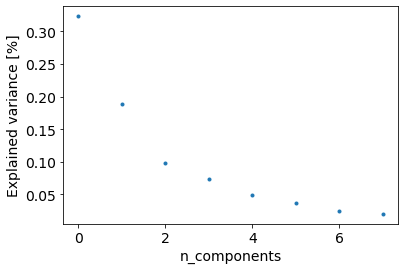

n_components: 8
Total explained variance: 81.59348584705882%


In [18]:
describe_pca(PDATA['pipeline'].named_steps['pca'])  

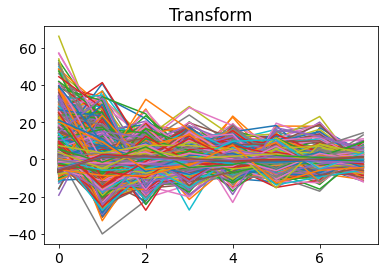

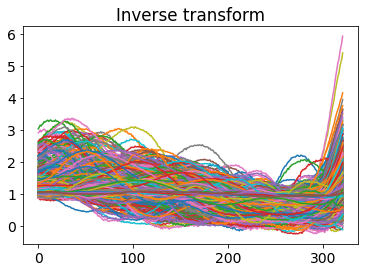

In [19]:
plt.title('Transform')
[plt.plot(x) for x in PDATA['X_train']]
plt.show()
plt.title('Inverse transform')
[plt.plot(PDATA['transformer'].inverse_transform(x)) for x in PDATA['X_train']]
plt.show()

## Train

In [25]:
def evaluate_model(model, X_test, y_test, froot=None):
    """Evaluate trained model."""
    print(metrics.classification_report(y_test, model.predict(X_test)))
    pr = metrics.plot_precision_recall_curve(model,
                                             X_test,
                                             y_test,
                                             name='Gradient Boosting')
    roc = metrics.plot_roc_curve(model,
                                 X_test,
                                 y_test,
                                 name='Gradient Boosting')
    cm = metrics.plot_confusion_matrix(
        model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        display_labels=[r'$\mathcal{M}_0$', r'$\mathcal{M}_1$'])
    if froot is not None:
        pr.figure_.tight_layout()
        pr.figure_.savefig(froot + 'pr.pdf')
        roc.figure_.tight_layout()
        roc.figure_.savefig(froot + 'roc.pdf')
        cm.figure_.tight_layout()
        cm.figure_.savefig(froot + 'cm.pdf')

In [21]:
%%time 

MODEL = build_model()
MODEL.fit(PDATA['X_train'], PDATA['y_train'])

CPU times: user 827 ms, sys: 108 ms, total: 936 ms
Wall time: 3.6 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [22]:
MODEL.best_params_

{'max_depth': 8, 'n_estimators': 200}

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       376
         1.0       1.00      0.99      0.99       436

    accuracy                           0.99       812
   macro avg       0.99      0.99      0.99       812
weighted avg       0.99      0.99      0.99       812



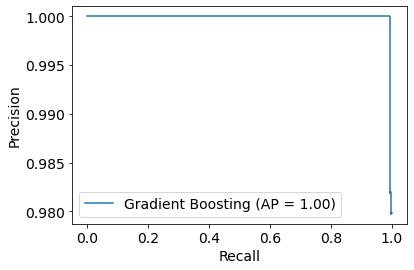

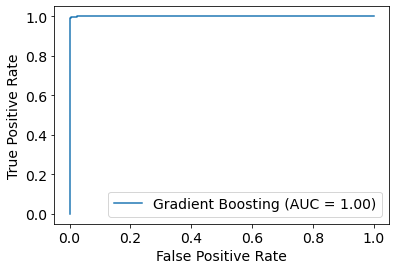

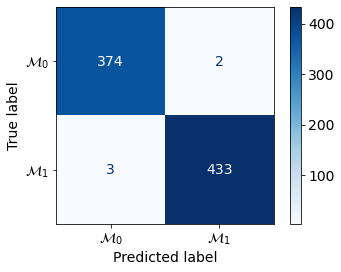

In [23]:
evaluate_model(MODEL, PDATA['X_val'], PDATA['y_val'])

In [24]:
# print(metrics.confusion_matrix(PDATA['y_val'], MODEL.predict(PDATA['X_val'])))

### Comparison with different numbers of PCAs

- n_components = 1 (33% total explained variance): 
  
  - Training time: 2 s.
  
  - Confusion matrix:
  ```
  [[364  12]
   [ 19 417]]
  ```

  - Metrics:
  
```
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       376
         1.0       0.97      0.96      0.96       436

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812
```

- n_components = 322 (100% total explained variance):
  
  - Training time: 50 s.
  
  - Confusion matrix:
  ```
  [[373   3]
   [  2 434]]
  ```
  - Metrics:
  
```
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       376
         1.0       0.99      1.00      0.99       436

    accuracy                           0.99       812
   macro avg       0.99      0.99      0.99       812
weighted avg       0.99      0.99      0.99       812
```

- no PCA:
  
  - Training time: 60 s.
  
  - Confusion matrix:
  ```
  [[376   0]
   [ 13 423]]
  ```
  - Metrics:
  
```
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       376
         1.0       1.00      0.97      0.98       436

    accuracy                           0.98       812
   macro avg       0.98      0.99      0.98       812
weighted avg       0.98      0.98      0.98       812
```

## Evaluate on test set

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       517
         1.0       0.99      0.99      0.99       566

    accuracy                           0.99      1083
   macro avg       0.99      0.99      0.99      1083
weighted avg       0.99      0.99      0.99      1083



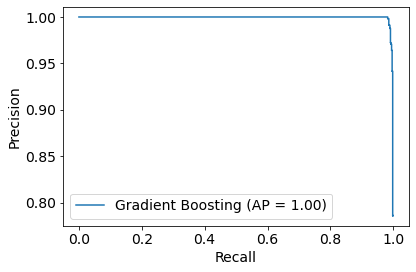

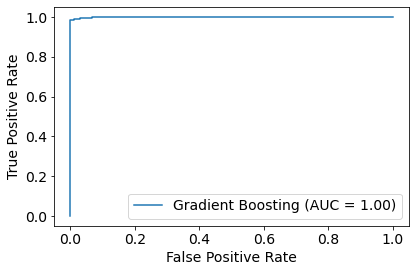

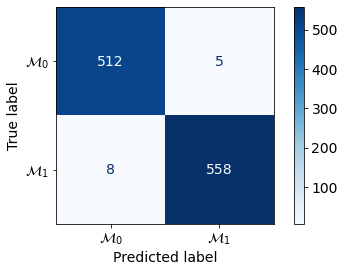

In [25]:
evaluate_model(MODEL, PDATA['X_test'], PDATA['y_test'], 
               froot='/home/francesco/Dropbox/Work/streams/plots/gb_')

# Multiclass, single-label classification of mass ranges

## Load data

In [6]:
DATA = load_data(
    '/home/francesco/Data/streams/scripts_data/Xy_obs_density_3classes.pkl',
    random_state=55)

Filtered 25 dens<0 samples


In [7]:
_STEPS = np.diff(DATA['ll'])
assert np.allclose(_STEPS - _STEPS[0], [0] * len(_STEPS))
print(f"Angular bins size: {_STEPS[0]} deg")

Angular bins size: 0.21811565630582663 deg


Note that classes are imbalanced, small masses (class 0) has twice the samples of the other cases.

In [8]:
for set_ in ['train', 'val', 'test']:
    print(f"{set_}:")
    print(f"  Shape X: {DATA['X_' + set_].shape}, y: {DATA['y_' + set_].shape}")
    print(
        f"  # of samples for the three categories: " + 
        f"({np.count_nonzero(DATA['y_' + set_]==0)}, " + 
        f"{np.count_nonzero(DATA['y_' + set_]==1)}, " +
        f"{np.count_nonzero(DATA['y_' + set_]==2)})"
    )

train:
  Shape X: (2436, 322), y: (2436,)
  # of samples for the three categories: (1162, 709, 565)
val:
  Shape X: (812, 322), y: (812,)
  # of samples for the three categories: (363, 262, 187)
test:
  Shape X: (1083, 322), y: (1083,)
  # of samples for the three categories: (502, 331, 250)


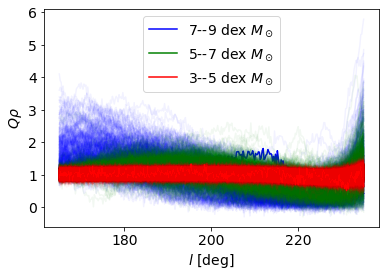

In [9]:
def plot_X(ll, X, y):
    """Plot Qrho samples."""
    fig, ax = plt.subplots()
    _plot_X_class(ax, ll, X, y, 2, 'b', r'7--9 dex $M_\odot$')
    _plot_X_class(ax, ll, X, y, 1, 'g', r'5--7 dex $M_\odot$')
    _plot_X_class(ax, ll, X, y, 0, 'r', r'3--5 dex $M_\odot$')
    ax.set_xlabel("$l$ [deg]")
    ax.set_ylabel(r"$Q\rho$")
    ax.legend()


plot_X(DATA['ll'], DATA['X_train'], DATA['y_train'])

## Preprocess data

In [10]:
PDATA = preprocess(DATA, n_components=64)
PDATA.keys()

dict_keys(['ll', 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'pipeline', 'transformer'])

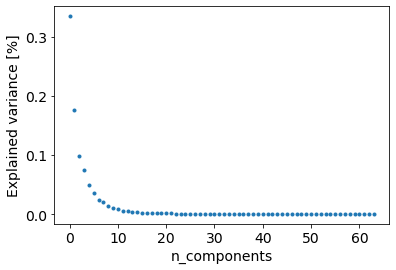

n_components: 64
Total explained variance: 90.58370737179338%


In [11]:
describe_pca(PDATA['pipeline'].named_steps['pca'])  

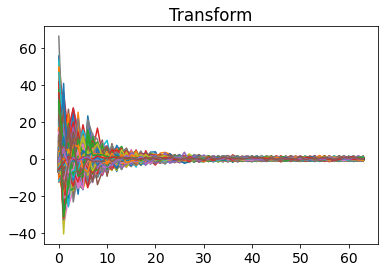

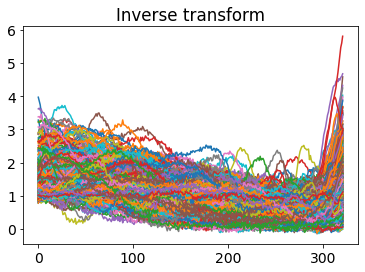

In [12]:
plt.title('Transform')
[plt.plot(x) for x in PDATA['X_train']]
plt.show()
plt.title('Inverse transform')
[plt.plot(PDATA['transformer'].inverse_transform(x)) for x in PDATA['X_train']]
plt.show()

## Train

In [13]:
def evaluate_multiclass_model(model, X_test, y_test, froot=None):
    """Evaluate trained model."""
    print(metrics.classification_report(y_test, model.predict(X_test)))
    cm = metrics.plot_confusion_matrix(model,
                                       X_test,
                                       y_test,
                                       cmap=plt.cm.Blues,
                                       display_labels=[
                                           r'$\mathcal{M}_0$',
                                           r'$\mathcal{M}_1$',
                                           r'$\mathcal{M}_2$'
                                       ])
    if froot is not None:
        cm.figure_.tight_layout()
        cm.figure_.savefig(froot + 'cm_3classes.pdf')

In [14]:
%%time 

MODEL = build_model()
MODEL.fit(PDATA['X_train'], PDATA['y_train'])

CPU times: user 14 s, sys: 88.4 ms, total: 14.1 s
Wall time: 1min 8s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       363
           1       0.94      0.94      0.94       262
           2       0.90      0.89      0.89       187

    accuracy                           0.95       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.95      0.95      0.95       812



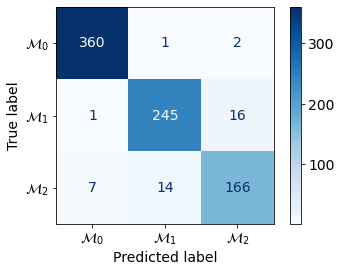

In [18]:
evaluate_multiclass_model(MODEL, PDATA['X_val'], PDATA['y_val'])

## Evaluate on test set

**Warning:** Classes 1 and 2 are imbalanced compared to class 0. Accuracy reflects this class imbalance and it is not informative.

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       502
           1       0.94      0.92      0.93       331
           2       0.91      0.92      0.91       250

    accuracy                           0.96      1083
   macro avg       0.95      0.95      0.95      1083
weighted avg       0.96      0.96      0.96      1083



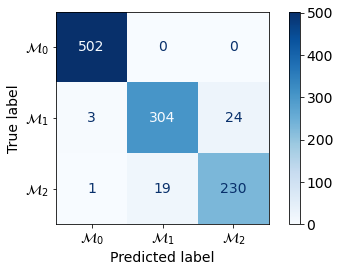

In [19]:
evaluate_multiclass_model(
    MODEL,
    PDATA['X_test'],
    PDATA['y_test'],
    froot='/home/francesco/Dropbox/Work/streams/plots/gb_')